[Original author](https://designwith.ml/assets/docs/Meetup_clustering_sample)  
  
Clustering meetup.com data! Using the location and group information to cluster the members into 6 clusters - but it is up to you to figure out what they mean!  

Data was on Kaggle.

In [1]:
#these are all of the libraries i'll be using - and I load the groups.csv data
import pandas as pd
import numpy as np
import random
import sklearn
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import matplotlib
%matplotlib inline
matplotlib.style.use('ggplot')

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
import pandas as pd

df = pd.read_csv("gdrive/My Drive/Work/UBB 2023/02_Cursuri/Session #5/data/groups.csv")

# Data Step
This step we're going to look at our dataframes and become familiar with what's in them.

In [5]:
#this is what the groups.csv looks like as a dataframe - it is about the groups
df.head()

,group_id,category_id,category.name,category.shortname,city_id,city,country,created,description,group_photo.base_url,...,organizer.photo.photo_link,organizer.photo.thumb_link,organizer.photo.type,rating,state,timezone,urlname,utc_offset,visibility,who
0,6388,14,health/wellbeing,health-wellbeing,10001,New York,US,2002-11-21 16:50:46,Those who practice or hold a strong interest i...,https://secure.meetupstatic.com,...,https://secure.meetupstatic.com/photos/member/...,https://secure.meetupstatic.com/photos/member/...,member,4.39,NY,US/Eastern,alternative-health-nyc,-14400,public,Explorers of Health
1,6510,4,community/environment,community-environment,10001,New York,US,2003-05-20 14:48:54,The New York Alternative Energy Meetupis for t...,https://secure.meetupstatic.com,...,https://secure.meetupstatic.com/photos/member/...,https://secure.meetupstatic.com/photos/member/...,member,4.31,NY,US/Eastern,alternative-energy-meetup,-14400,public,Clean Energy Supporters
2,8458,26,pets/animals,pets-animals,10001,New York,US,2004-03-27 09:55:41,not_found,https://secure.meetupstatic.com,...,https://secure.meetupstatic.com/photos/member/...,https://secure.meetupstatic.com/photos/member/...,member,4.84,NY,US/Eastern,Animals,-14400,public,Animal Voices
3,8940,29,sci-fi/fantasy,sci-fi-fantasy,10001,New York,US,2002-11-16 04:49:16,Welcome to the The New York City Anime Meetup ...,https://secure.meetupstatic.com,...,https://secure.meetupstatic.com/photos/member/...,https://secure.meetupstatic.com/photos/member/...,member,4.46,NY,US/Eastern,NYC-Anime,-14400,public,Anime Fans
4,10104,26,pets/animals,pets-animals,10001,New York,US,2003-10-22 21:39:49,"We welcome those who support pits, even if you...",https://secure.meetupstatic.com,...,https://secure.meetupstatic.com/photos/member/...,https://secure.meetupstatic.com/photos/member/...,member,4.09,NY,US/Eastern,NYC-Pitbull,-14400,public_limited,"NYC Pits & People, Dog Lovers"


In [6]:
#this is the df about the members
df2 = pd.read_csv("gdrive/My Drive/Work/UBB 2023/02_Cursuri/Session #5/data/members.csv", encoding = "ISO-8859-1" , nrows=1600133) #  This encoding is commonly used for Western European languages and is a single-byte encoding that can represent a wide range of characters, including characters with accents and diacritics.

In [8]:
df2.shape

(1600133, 14)

In [7]:
df2.head()

,member_id,bio,city,country,hometown,joined,lat,link,lon,member_name,state,member_status,visited,group_id
0,3,not_found,New York,us,"New York, NY",2007-05-01 22:04:37,40.72,http://www.meetup.com/members/3,-74.0,Matt Meeker,NY,active,2009-09-18 18:32:23,490552
1,3,not_found,New York,us,"New York, NY",2011-01-23 14:13:17,40.72,http://www.meetup.com/members/3,-74.0,Matt Meeker,NY,active,2011-03-20 01:02:11,1474611
2,3,"Hi, I'm Matt. I'm an entrepreneur who has star...",New York,us,"New York, NY",2010-12-30 18:47:34,40.72,http://www.meetup.com/members/3,-74.0,Matt Meeker,NY,active,2011-01-18 20:37:23,1490492
3,3,"Hi, I'm Matt. I'm an entrepreneur who has star...",New York,us,"New York, NY",2011-01-03 14:45:21,40.72,http://www.meetup.com/members/3,-74.0,Matt Meeker,NY,active,2011-07-23 03:42:28,1515830
4,3,"Hi, I'm Matt. I'm an entrepreneur who has star...",New York,us,"New York, NY",2010-12-30 18:34:50,40.72,http://www.meetup.com/members/3,-74.0,Matt Meeker,NY,active,2011-06-13 18:33:23,1574965


## Data Cleaning Phase
In this phase, we'll sample a % of the data, and then use "one hot" encoding to turn string features into numbers for our mathematical models.

In [9]:
# I am sampling to 5,000 random samples from the dataframe since it is just SOOO big! This will help my code run faster
df2_sample = df2.sample(n=5000)

In [ ]:
#let's explore the df by member id and the first record number of each - what are the features we want to use?
# group a DataFrame (df2_sample) by the 'member_id' column and then select the first row within each group.
# This operation is often used to get the first entry or a representative entry for each unique member ID.
df2_sample.groupby(['member_id']).first()

,bio,city,country,hometown,joined,lat,link,lon,member_name,state,member_status,visited,group_id
member_id,,,,,,,,,,,,,
8352,not_found,New York,us,not_found,2007-06-11 19:21:19,40.75,http://www.meetup.com/members/8352,-73.99,Frank Purcell,NY,active,2007-06-18 03:10:53,500018
10405,not_found,San Francisco,us,Corte Madera,2015-02-02 20:39:06,37.78,http://www.meetup.com/members/10405,-122.49,Chris Kraynik,CA,active,2016-11-10 06:39:02,18201244
10548,not_found,Chicago,us,Chicago,2008-12-31 21:27:23,41.96,http://www.meetup.com/members/10548,-87.66,Dave Schneider,IL,active,2017-01-27 09:59:41,1034045
15420,"24, M, living in the lower east village. Look...",New York,us,not_found,2003-01-14 22:19:42,40.75,http://www.meetup.com/members/15420,-73.99,djx101,NY,active,2004-08-05 02:48:10,110560
23027,meh,New York,us,New York,2014-06-27 18:28:39,40.75,http://www.meetup.com/members/23027,-73.99,Warren Lindsey,NY,active,2017-08-21 02:45:58,15288302
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48343352,Michael Duda,New York,us,not_found,2014-03-22 18:53:53,40.75,http://www.meetup.com/members/48343352,-73.99,Michael Duda,NY,active,2017-10-27 20:32:52,6143802
48359112,not_found,New York,us,not_found,2016-05-03 17:31:35,40.78,http://www.meetup.com/members/48359112,-73.95,Jerome,NY,active,2016-11-04 17:01:15,18572595
48368052,not_found,San Francisco,us,not_found,2012-05-22 17:28:30,37.77,http://www.meetup.com/members/48368052,-122.41,Amanda,CA,active,2012-05-22 17:28:30,1321520


df2_sample['group_id']: This extracts the 'group_id' column from the DataFrame df2_sample.  
pd.get_dummies(...): This function converts categorical variable(s) into dummy/indicator variables. In this case, it's applied to the 'group_id' column.  
prefix='group_id': This parameter adds a prefix to the newly created dummy variable columns to indicate their association with the original 'group_id'.  
  
  The resulting df2_sample_dummies DataFrame will contain new binary columns (0 or 1) for each unique value in the 'group_id' column. Each row will have a 1 in the column corresponding to its 'group_id' and 0s in the other columns.

In [11]:
#One feature I want to use is the GROUP ID - one thing that we can do is "get dummies" or "one-hot encoding" to
#turn string variables into numbers! look at it below
df2_sample_dummies = pd.get_dummies(df2_sample['group_id'], prefix = 'group_id')

In [12]:
#this is what it looks like to have "dummies" or one-hot encoded variables!
df2_sample_dummies.head()

,group_id_6388,group_id_6510,group_id_8458,group_id_8940,group_id_12542,group_id_12907,group_id_15324,group_id_22211,group_id_24765,group_id_25709,...,group_id_26014094,group_id_26112811,group_id_26187030,group_id_26205767,group_id_26220929,group_id_26234228,group_id_26263635,group_id_26268961,group_id_26301058,group_id_26341790
905931,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1553078,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
344590,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1223707,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
989028,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
#Let's combine it back to our original dataframe
df2_sample_dummies_concat = pd.concat([df2_sample, df2_sample_dummies], axis=1)

In [14]:
df2_sample_dummies_concat.head()

,member_id,bio,city,country,hometown,joined,lat,link,lon,member_name,...,group_id_26014094,group_id_26112811,group_id_26187030,group_id_26205767,group_id_26220929,group_id_26234228,group_id_26263635,group_id_26268961,group_id_26301058,group_id_26341790
905931,12551969,not_found,Chicago,us,San Francisco,2015-01-11 21:00:19,41.88,http://www.meetup.com/members/12551969,-87.62,Eric,...,0,0,0,0,0,0,0,0,0,0
1553078,44843142,not_found,New York,us,not_found,2016-01-15 14:33:53,40.75,http://www.meetup.com/members/44843142,-73.99,Bill Pecoriello,...,0,0,0,0,0,0,0,0,0,0
344590,6591023,not_found,San Francisco,us,San Francisco,2015-06-26 21:32:53,37.80,http://www.meetup.com/members/6591023,-122.40,Olle,...,0,0,0,0,0,0,0,0,0,0
1223707,19087351,not_found,New York,us,not_found,2016-08-20 20:16:19,40.75,http://www.meetup.com/members/19087351,-73.99,Tish,...,0,0,0,0,0,0,0,0,0,0
989028,13260862,not_found,San Francisco,us,San Francisco,2014-10-09 22:06:49,37.77,http://www.meetup.com/members/13260862,-122.44,Asher Blumberg,...,0,0,0,0,0,0,0,0,0,0


In [15]:
#let's repeat the same process for the "cities" feature
df2_sample_dummies_cities = pd.get_dummies(df2_sample_dummies_concat['city'], prefix = 'cities_')
df2_sample_dummies_concat_cities2 = pd.concat([df2_sample_dummies_concat, df2_sample_dummies_cities], axis=1)

In [16]:
df2_sample_dummies_concat_cities2.head()

,member_id,bio,city,country,hometown,joined,lat,link,lon,member_name,...,group_id_26268961,group_id_26301058,group_id_26341790,cities__Chicago,cities__Chicago Heights,cities__New York,cities__San Francisco,cities__South San Francisco,cities__West Chicago,cities__West New York
905931,12551969,not_found,Chicago,us,San Francisco,2015-01-11 21:00:19,41.88,http://www.meetup.com/members/12551969,-87.62,Eric,...,0,0,0,1,0,0,0,0,0,0
1553078,44843142,not_found,New York,us,not_found,2016-01-15 14:33:53,40.75,http://www.meetup.com/members/44843142,-73.99,Bill Pecoriello,...,0,0,0,0,0,1,0,0,0,0
344590,6591023,not_found,San Francisco,us,San Francisco,2015-06-26 21:32:53,37.80,http://www.meetup.com/members/6591023,-122.40,Olle,...,0,0,0,0,0,0,1,0,0,0
1223707,19087351,not_found,New York,us,not_found,2016-08-20 20:16:19,40.75,http://www.meetup.com/members/19087351,-73.99,Tish,...,0,0,0,0,0,1,0,0,0,0
989028,13260862,not_found,San Francisco,us,San Francisco,2014-10-09 22:06:49,37.77,http://www.meetup.com/members/13260862,-122.44,Asher Blumberg,...,0,0,0,0,0,0,1,0,0,0


In [17]:
#write it to a CSV before your kernel dies! this could be helpful if you want to use the same sample again in the future
df2_sample_dummies_concat_cities2.to_csv('members2.csv')

In [19]:
!cp members2.csv "gdrive/My Drive/Work/UBB 2023/02_Cursuri/Session #5/data/"

## Training the model
We will use groupIDs and Cities as our main features to train the model - and since we want the data itself to group and tell us what the major groups are - we are going to use a technique called "clustering" (or k-means clustering, where k= the number of clusters). I don't know in advance what the best number of clusters will be, so I will try a bunch of different k (k= 2,4,6,8) and then see how well our clusters are performing. See below :)

In [20]:
df2_sample_dummies_concat_cities2_train = df2_sample_dummies_concat_cities2.loc[:, 'group_id_6388':'cities__West New York']
df2_sample_dummies_concat_cities2_train.head()

,group_id_6388,group_id_6510,group_id_8458,group_id_8940,group_id_12542,group_id_12907,group_id_15324,group_id_22211,group_id_24765,group_id_25709,...,group_id_26268961,group_id_26301058,group_id_26341790,cities__Chicago,cities__Chicago Heights,cities__New York,cities__San Francisco,cities__South San Francisco,cities__West Chicago,cities__West New York
905931,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1553078,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
344590,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1223707,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
989028,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [21]:
#k = 8 training model
km = KMeans(n_clusters=8)
%time km.fit(df2_sample_dummies_concat_cities2_train)
clusters = km.labels_.tolist()
%time km.fit(df2_sample_dummies_concat_cities2_train)
silhouette_k8 = silhouette_score(df2_sample_dummies_concat_cities2_train[0:5000], clusters[0:5000])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


CPU times: user 8.04 s, sys: 1.45 s, total: 9.49 s
Wall time: 5.49 s


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


CPU times: user 7.39 s, sys: 840 ms, total: 8.23 s
Wall time: 4.45 s


In [23]:
#k=6 training model
km = KMeans(n_clusters=6)
%time km.fit(df2_sample_dummies_concat_cities2_train)
clusters = km.labels_.tolist()
%time km.fit(df2_sample_dummies_concat_cities2_train)
silhouette_k6 = silhouette_score(df2_sample_dummies_concat_cities2_train[0:5000], clusters[0:5000])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


CPU times: user 5.77 s, sys: 904 ms, total: 6.68 s
Wall time: 3.68 s


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


CPU times: user 4.35 s, sys: 477 ms, total: 4.83 s
Wall time: 6.75 s


In [24]:
# k = 4 training model
km = KMeans(n_clusters=4)
%time km.fit(df2_sample_dummies_concat_cities2_train)
clusters = km.labels_.tolist()
%time km.fit(df2_sample_dummies_concat_cities2_train)
silhouette_k4 = silhouette_score(df2_sample_dummies_concat_cities2_train[0:5000], clusters[0:5000])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


CPU times: user 4.41 s, sys: 1.04 s, total: 5.44 s
Wall time: 3.01 s


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


CPU times: user 3.73 s, sys: 784 ms, total: 4.52 s
Wall time: 4 s


In [25]:
# k = 2 training model
km = KMeans(n_clusters=2)
%time km.fit(df2_sample_dummies_concat_cities2_train)
clusters = km.labels_.tolist()
%time km.fit(df2_sample_dummies_concat_cities2_train)
silhouette_k2 = silhouette_score(df2_sample_dummies_concat_cities2_train[0:5000], clusters[0:5000])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


CPU times: user 2.73 s, sys: 849 ms, total: 3.58 s
Wall time: 2.02 s


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


CPU times: user 3.14 s, sys: 971 ms, total: 4.11 s
Wall time: 2.31 s


## Model Evaluation


In [26]:
silhouette = [silhouette_k2, silhouette_k4, silhouette_k6, silhouette_k8]
count_k = [2, 4, 6, 8]

count_silhouette = list(zip(count_k, silhouette))
print(count_silhouette)

[(2, 0.23463933792138547), (4, 0.2929464113392071), (6, 0.050261011404846206), (8, 0.10947864946162009)]


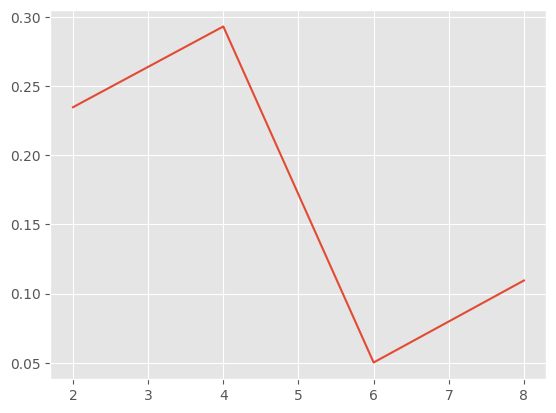

In [27]:
plt.plot(*zip(*count_silhouette))

* No Clear Elbow:
If the inertia plot doesn't show a clear elbow and the inertia decreases smoothly without a significant break point, it might be challenging to determine the optimal k based solely on this method.  
  
* Slight Elbow:
If there's a slight elbow, it suggests that adding more clusters beyond that point provides diminishing returns in terms of explaining the variance in the data.  
  
* Sharp Elbow:
If there's a sharp elbow, it indicates a more pronounced point where the addition of clusters is less beneficial. This is often considered a good candidate for the optimal number of clusters.  

  However, it's important to note that the elbow method has limitations, and the choice of k may not always be entirely clear-cut. It's often used as a heuristic rather than a strict rule. Other factors, such as domain knowledge, the context of the problem, and the specific characteristics of the data, should also be considered.

## Model Output
Now that we've decided on k=4 clusters, let's assign the cluster labels back to the original data, and make it interpretable!

In [28]:
km = KMeans(n_clusters=4)
%time km.fit(df2_sample_dummies_concat_cities2_train)
clusters4 = km.labels_.tolist()
silhouette_k4 = silhouette_score(df2_sample_dummies_concat_cities2_train[0:50000], clusters[0:50000])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


CPU times: user 3.65 s, sys: 449 ms, total: 4.1 s
Wall time: 7.1 s


In [29]:
df2_sample_dummies_concat_cities2_train.loc[:, "cluster_number"] = clusters4

In [30]:
df2_sample_dummies_concat_cities2_train.head()

,group_id_6388,group_id_6510,group_id_8458,group_id_8940,group_id_12542,group_id_12907,group_id_15324,group_id_22211,group_id_24765,group_id_25709,...,group_id_26301058,group_id_26341790,cities__Chicago,cities__Chicago Heights,cities__New York,cities__San Francisco,cities__South San Francisco,cities__West Chicago,cities__West New York,cluster_number
905931,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1553078,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,3
344590,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,2
1223707,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,3
989028,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,2


In [31]:
df2_sample_dummies_concat_cities2_train["cluster_number"].value_counts()

3    2929
2    1257
1     794
0      20
Name: cluster_number, dtype: int64

## Tadah! We have a merged dataframe of members, clustered by their city and groups they're interested in, merged on what the group categories are (from the original groups df) and we can now export this and explore!

In [32]:
df2_sample.head()

,member_id,bio,city,country,hometown,joined,lat,link,lon,member_name,state,member_status,visited,group_id
905931,12551969,not_found,Chicago,us,San Francisco,2015-01-11 21:00:19,41.88,http://www.meetup.com/members/12551969,-87.62,Eric,IL,active,2016-11-19 21:15:35,1741214
1553078,44843142,not_found,New York,us,not_found,2016-01-15 14:33:53,40.75,http://www.meetup.com/members/44843142,-73.99,Bill Pecoriello,NY,active,2016-01-15 14:33:53,3736372
344590,6591023,not_found,San Francisco,us,San Francisco,2015-06-26 21:32:53,37.80,http://www.meetup.com/members/6591023,-122.40,Olle,CA,active,2015-07-15 14:03:16,18692118
1223707,19087351,not_found,New York,us,not_found,2016-08-20 20:16:19,40.75,http://www.meetup.com/members/19087351,-73.99,Tish,NY,active,2016-08-20 20:16:19,19851643
989028,13260862,not_found,San Francisco,us,San Francisco,2014-10-09 22:06:49,37.77,http://www.meetup.com/members/13260862,-122.44,Asher Blumberg,CA,active,2015-09-29 00:23:12,6230762


In [34]:
df2_sample.loc[:, "clusters_number"] = clusters4

In [35]:
df2_sample.to_csv('members_cluster_group.csv')

In [36]:
!cp members_cluster_group.csv "gdrive/My Drive/Work/UBB 2023/02_Cursuri/Session #5/data/"

In [38]:
df2_sample.head()

,member_id,bio,city,country,hometown,joined,lat,link,lon,member_name,state,member_status,visited,group_id,clusters_number
905931,12551969,not_found,Chicago,us,San Francisco,2015-01-11 21:00:19,41.88,http://www.meetup.com/members/12551969,-87.62,Eric,IL,active,2016-11-19 21:15:35,1741214,1
1553078,44843142,not_found,New York,us,not_found,2016-01-15 14:33:53,40.75,http://www.meetup.com/members/44843142,-73.99,Bill Pecoriello,NY,active,2016-01-15 14:33:53,3736372,3
344590,6591023,not_found,San Francisco,us,San Francisco,2015-06-26 21:32:53,37.80,http://www.meetup.com/members/6591023,-122.40,Olle,CA,active,2015-07-15 14:03:16,18692118,2
1223707,19087351,not_found,New York,us,not_found,2016-08-20 20:16:19,40.75,http://www.meetup.com/members/19087351,-73.99,Tish,NY,active,2016-08-20 20:16:19,19851643,3
989028,13260862,not_found,San Francisco,us,San Francisco,2014-10-09 22:06:49,37.77,http://www.meetup.com/members/13260862,-122.44,Asher Blumberg,CA,active,2015-09-29 00:23:12,6230762,2


In [39]:
df2_sample['city'].nunique()

7

In [40]:
df2_sample['group_id'].nunique()

2712